In [1]:
import block_methods as BM

from Lanczos_FA.lanczos_bin import *

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import integrate
plt.rcParams["figure.figsize"] = (16,9)

In [30]:
n = 1000
w = 0
step = 10
K = 200
lam = np.linspace(1e-2,1e2,n)

A = np.diag(lam)
b = np.ones((n, 1))
b /= np.linalg.norm(b)

In [3]:
def Gamma(t):
    radius = lmax_ - lmin_/100

    z = radius*np.exp(1j*t)+lmax_
    dz = radius*1j*np.exp(1j*t)
    
    return z,dz

def f(x):
    return np.sqrt(x)

In [4]:
# def get_a_posteriori_bound(f,gamma,endpts,a_,b_,w,lmin,lmax):
#     """
#     (1/2pi) \oint_{\Gamma} |f(z)| |D_{k,w,z}| Q_{w,z} |dz|
#     """
    
#     theta = sp.linalg.eigvalsh_tridiagonal(a_,b_,tol=1e-30)

#     def F(t):
#         z,dz = gamma(t)
        
#         return (1/(2*np.pi)) * np.abs(f(z)) * np.abs(np.prod((theta-w)/(theta-z))) * Q_wz(w,z,lmin,lmax) * np.abs(dz)
    
#     integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200) 
    
#     return integral

# this deals with h_wz
def Q_wz(w,z,lmin,lmax):
    """
    max_{x\in[lmin,lmax]} |x-w|/|z-w|
    """
    
    if np.real(z) - w != 0:
        b_hat = ( np.abs(z)**2 - np.real(z)*w ) / (np.real(z) - w)
    else:
        b_hat = np.inf
    
    if lmin < b_hat <= lmax:
        return np.abs((z-w)/np.imag(z))
    else:
        return np.max([np.abs((lmax-w)/(lmax-z)), np.abs((lmin-w)/(lmin-z))])

In [5]:
def get_cwinvcz(Eval, Evec, z, w, itr, b, B_0):
    Dzinv = np.diag(1/(Eval-z))
    Dwinv = np.diag(1/(Eval-w))
        
    if b == 1:
        Cz = Evec@Dzinv@Evec.T@BM.Ei(itr*b, b, 1)*B_0
        Cwinv = np.linalg.solve(-BM.Ei(itr*b, b, itr).T@Evec@Dwinv@Evec.T@BM.Ei(itr*b, b, 1)*B_0, -BM.Ei(itr*b, b, itr).T)
    else:
        Cz = Evec@Dzinv@Evec.T@BM.Ei(itr*b, b, 1)@B_0
        Cwinv = np.linalg.solve(-BM.Ei(itr*b, b, itr).T@Evec@Dwinv@Evec.T@BM.Ei(itr*b, b, 1)@B_0, -BM.Ei(itr*b, b, itr).T)
    
    return Cwinv@Cz


def block_a_posteriori_bound(T, f,gamma,endpts,w,lmin,lmax, itr, B_0):
    """
    (1/2pi) \oint_{\Gamma} |f(z)| |D_{k,w,z}| Q_{w,z} |dz|
    """
    Eval, Evec = np.linalg.eigh(T)
    def F(t):
        z,dz = gamma(t)
        
        return (1/(2*np.pi)) * np.abs(f(z)) * np.linalg.norm(get_cwinvcz(Eval, Evec, z, w, itr, np.shape(B_0)[0], B_0)) * Q_wz(w,z,lmin,lmax) * np.abs(dz)
    
    integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200) 
    
    return integral

In [6]:
# def comparison(w, z, a_, b_, itr, B_0):
#     T = np.diag(a_.astype(np.double)) + np.diag(b_.astype(np.double), 1) + np.diag(b_.astype(np.double), -1)
#     Eval, Evec = np.linalg.eigh(T)
    
#     theta = sp.linalg.eigvalsh_tridiagonal(a_,b_,tol=1e-30)
    
#     return (np.abs(np.linalg.norm(get_cwinvcz(Eval, Evec, z, w, itr, 1, B_0)) - np.abs(np.prod((theta-w)/(theta-z)))), np.linalg.norm(get_cwinvcz(Eval, Evec, z, w, itr, 1, B_0)))

In [7]:
lmin = np.min(lam).astype(np.double)
lmax = np.max(lam).astype(np.double)
kappa = lmax / lmin

lmin_ = lmin/2
lmax_ = 2*lmax

# norm to measure function approximation and linear system errors
B = lam


Q, Qkp1, a_, b_ = BM.block_lanczos(A, np.reshape(b, (b.size, 1)), K, K+1)

T = BM.get_block_tridiag(a_, b_[1:])

# e1 = np.zeros(K+1)
# e1[0] = 1

In [8]:
# term_error = np.full(K,np.inf)
# term = np.full(K,np.inf)
# block_bound = np.full(K,np.inf)
# old_bound = np.full(K,np.inf)


# for k in range(1,int((K+1)/step)):
#     B_0 = 1
#     k = step*k
#     term_error[int((k-1)/step)] = comparison(w, 1, a_[:k], b_[:k-1], k, B_0)[0]
#     term[int((k-1)/step)] = comparison(w, 1, a_[:k], b_[:k-1], k, B_0)[1]
#     block_bound[int((k-1)/step)] = block_a_posteriori_bound(f,Gamma,[0,np.pi],a_[:k],b_[:k-1],w,lmin_,lmax_, k, 1, B_0)[0]
#     old_bound[int((k-1)/step)] = get_a_posteriori_bound(f,Gamma,[0,np.pi],a_[:k],b_[:k-1],w,lmin_,lmax_)[0]

In [9]:
# x = np.linspace(1, K, 200)
# # plt.plot(x, a_posteriori_bound_circle_approx_spectrum, c='red')
# # plt.plot(x, compare, c='green')
# plt.plot(x*step, np.abs(block_bound-old_bound), label = "Total absolute difference")
# plt.plot(x*step, np.abs(block_bound-old_bound)/block_bound, label = "Total relative difference")
# plt.plot(x*step, term_error, label = "New term absolute difference")
# plt.plot(x*step, term_error/term, label = "New term relative difference")
# plt.yscale('log')
# plt.xlabel("k")
# plt.ylabel("error")
# plt.legend()
# plt.show

In [10]:
def block_a_posteriori_bound_mid(T, f, gamma, endpts, Q, A, b, B_0):
    """
    (1/2pi) \oint_{\Gamma} |f(z)| |D_{k,w,z}| Q_{w,z} |dz|
    """
    
    Eval, Evec = np.linalg.eigh(T)
    def F(t):
        z,dz = gamma(t)
        
        return (1/(2*np.pi)) * np.linalg.norm(f(z)* exact_err(z, A, b, Q, T, B_0)) * np.abs(dz)
    
    integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200) 
    
    return integral

In [11]:
# def block_a_posteriori_bound_exact(T, f, H, V, Q, B_0, b):
# # This integrand is a vector.SP seems to be not happy about that, so compute with the first line (f(H).....) instead
#     EvalH, EvecH = np.linalg.eigh(H)
#     fEvalH = f(EvalH)
#     fH = EvecH@np.diag(fEvalH)@EvecH.conj().T
    
#     EvalT, EvecT = np.linalg.eigh(T)
#     fEvalT = f(EvalT)
#     fT = EvecT@np.diag(fEvalT)@EvecT.conj().T
    
#     if b == 1:
#         return np.linalg.norm(fH@V-(Q@fT)[:, 0]*B_0)
    
#     return np.linalg.norm(fH@V-(Q@fT)[:, 0]@B_0)

In [52]:
def block_a_posteriori_bound_exact(T, f, H, V, Q, B_0, bsize):
    EvalH, EvecH = np.linalg.eigh(H)
    fEvalH = f(EvalH)
    fH = EvecH@np.diag(fEvalH)@EvecH.conj().T
    
    EvalT, EvecT = np.linalg.eigh(T)
#     EvalT may be negative, and np.sqrt only let imaginary output when input is complex
#     thus, we make first element of EvalT complex first. 
    EvalT = EvalT.astype(complex)
    EvalT[0] = EvalT[0]+0j
    
    fEvalT = f(EvalT)
    fT = EvecT@np.diag(fEvalT)@EvecT.conj().T
    
#     changed the line below, was:
#   return np.linalg.norm(fH@V-(Q@fT)[:, 0]@B_0)
#   reason: should keep the first column of block, as opposed to first col.
    return np.linalg.norm(np.reshape(fH@V, (n, bsize)).T-((Q@fT)[:, :bsize]@B_0).T)

In [13]:
# # use linear solver as oppose to get inverse
# def exact_err(z, H, V, Q, T, B_0):
#     Hinv = 1/(np.diag(H)-z)
# #     HinvV2 = Hinv*V
    
# #     NOTE: apparently this implementation further tanks performance as its nolonger "vectorized".
# #     Below is the new way of computing HinvV for better compatibility with block size larger than 1.
# #     Above commented out was the old code that only works with block size 1
# #     this if statement checks if V is 1d, aka block size = 1. If true, reshape to 2D format for compatibility
#     if (np.shape(np.shape(V))[0] == 1): 
#         V = np.reshape(V, (len(V), 1))
        
#     HinvV = np.zeros(np.shape(V),dtype = 'complex_')
#     for i in np.arange(np.shape(V)[1]):
#         HinvV[:, i] = Hinv*V[:, i]
    
# #     due to mismatched shape, we do transpose
#     HinvV = HinvV.T
    
# #     print(np.linalg.norm(HinvV-HinvV2))
    
#     E1 = BM.Ei(np.shape(T)[0], np.shape(B_0)[0], 1)
# #     E1_array = np.reshape(E1, len(E1))
#     TinvE = np.linalg.solve((T-z*np.eye(T.shape[0])), E1)
#     return HinvV.T - Q@TinvE*B_0

In [25]:
def exact_err(z, H, V, Q, T, B_0):
    Hinv = 1/(np.diag(H)-z)
#     HinvV2 = Hinv*V
    
#     NOTE: apparently this implementation further tanks performance as its nolonger "vectorized".
#     Below is the new way of computing HinvV for better compatibility with block size larger than 1.
#     Above commented out was the old code that only works with block size 1
#     this if statement checks if V is 1d, aka block size = 1. If true, reshape to 2D format for compatibility
    if (np.shape(np.shape(V))[0] == 1): 
        V = np.reshape(V, (len(V), 1))
        
    HinvV = np.zeros(np.shape(V),dtype = 'complex_')
    for i in np.arange(np.shape(V)[1]):
        HinvV[:, i] = Hinv*V[:, i]
    
#     due to mismatched shape, we do transpose
    HinvV = HinvV.T
    
#     print(np.linalg.norm(HinvV-HinvV2))

    E1 = BM.Ei(np.shape(T)[0], np.shape(B_0)[0], 1)
#     E1_array = np.reshape(E1, len(E1))
    TinvE = np.linalg.solve((T-z*np.eye(T.shape[0])), E1)
#     This line below is changed
    return HinvV.T - Q@TinvE@B_0

In [50]:
block_mid = np.full(K,np.inf)
block_exact = np.full(K,np.inf)
block_bound = np.full(K,np.inf)

for k in range(1,int((K+1)/step)):
    k = step*k
    B_0 = b_[0]
#     block_mid[int((k-1)/step)] = block_a_posteriori_bound_mid(T[:k, :k], f,Gamma,[0,np.pi], Q[:, :k], A, b.astype(np.double), B_0)[0]
    block_exact[int((k-1)/step)] = block_a_posteriori_bound_exact(T[:k, :k], f,A.astype(np.double), b.astype(np.double),Q[:, :k], B_0, 1)
#     block_bound[int((k-1)/step)] = block_a_posteriori_bound(T[:k, :k], f,Gamma,[0,np.pi],w,lmin_,lmax_, k, B_0)[0]

In [16]:
full_block_bound = np.full(K,np.inf)

for k in range(1,int((K+1)/step)):
    k = step*k
    B_0 = b_[0]
    full_block_bound[int((k-1)/step)] = block_bound[int((k-1)/step)]*np.linalg.norm(exact_err(w, A, b, Q[:, :k], T[:k, :k], B_0))

<function matplotlib.pyplot.show(close=None, block=None)>

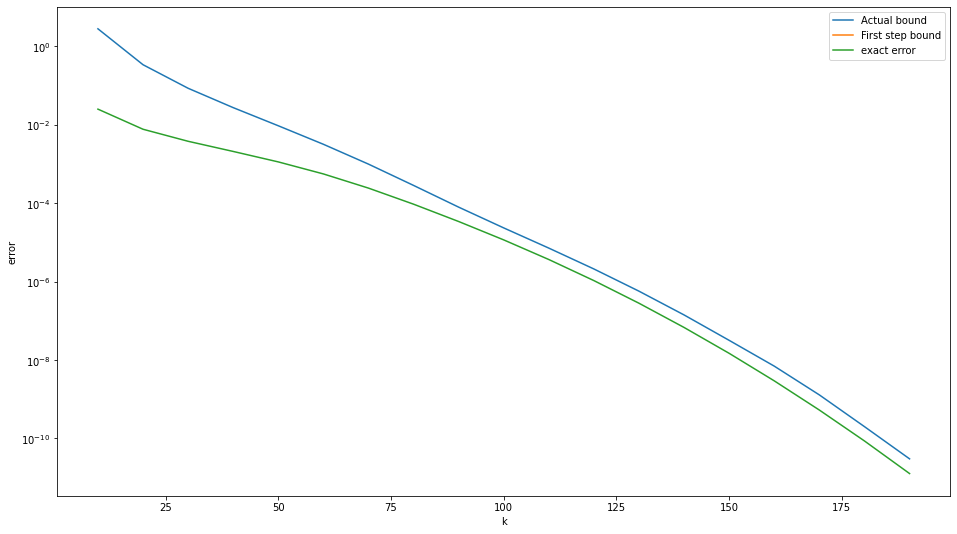

In [53]:
x = np.linspace(1, K, 200)

plt.plot(x*step, np.abs(full_block_bound), label = "Actual bound")
plt.plot(x*step, np.abs(block_mid), label = "First step bound")
plt.plot(x*step, np.abs(block_exact), label = "exact error")


plt.yscale('log')
plt.xlabel("k")
plt.ylabel("error")
plt.legend()
plt.show

In [31]:
EvalH, EvecH = np.linalg.eigh(A)
fEvalH = f(EvalH)
fH = EvecH@np.diag(fEvalH)@EvecH.conj().T
EvalT, EvecT = np.linalg.eigh(T)
EvalT = EvalT.astype(complex)
EvalT[0] = EvalT[0]+0j
    
fEvalT = f(EvalT)
fT = EvecT@np.diag(fEvalT)@EvecT.conj().T

In [35]:
np.shape(np.reshape(fH@b, (n, 1)).T-(Q@fT)[:, :2]*1)

ValueError: operands could not be broadcast together with shapes (1,1000) (1000,2) 

In [46]:
(Q@fT)[:, 0]

array([-0.00316228+0.j, -0.01049238+0.j, -0.01449759+0.j, -0.01761449+0.j,
       -0.02025735+0.j, -0.02259315+0.j, -0.02470912+0.j, -0.02665766+0.j,
       -0.02847316+0.j, -0.03017964+0.j, -0.03179467+0.j, -0.03333153+0.j,
       -0.03480059+0.j, -0.0362101 +0.j, -0.03756676+0.j, -0.0388761 +0.j,
       -0.04014276+0.j, -0.04137066+0.j, -0.04256315+0.j, -0.04372313+0.j,
       -0.04485311+0.j, -0.04595532+0.j, -0.04703171+0.j, -0.04808401+0.j,
       -0.04911377+0.j, -0.05012237+0.j, -0.05111108+0.j, -0.05208102+0.j,
       -0.05303322+0.j, -0.05396863+0.j, -0.05488809+0.j, -0.05579241+0.j,
       -0.0566823 +0.j, -0.05755843+0.j, -0.05842143+0.j, -0.05927186+0.j,
       -0.06011026+0.j, -0.06093713+0.j, -0.06175292+0.j, -0.06255808+0.j,
       -0.06335301+0.j, -0.06413808+0.j, -0.06491366+0.j, -0.06568009+0.j,
       -0.06643767+0.j, -0.06718671+0.j, -0.06792749+0.j, -0.06866028+0.j,
       -0.06938533+0.j, -0.07010288+0.j, -0.07081317+0.j, -0.07151639+0.j,
       -0.07221277+0.j, -

In [48]:
(Q@fT)[:, :1].T

array([[-0.00316228+0.j, -0.01049238+0.j, -0.01449759+0.j,
        -0.01761449+0.j, -0.02025735+0.j, -0.02259315+0.j,
        -0.02470912+0.j, -0.02665766+0.j, -0.02847316+0.j,
        -0.03017964+0.j, -0.03179467+0.j, -0.03333153+0.j,
        -0.03480059+0.j, -0.0362101 +0.j, -0.03756676+0.j,
        -0.0388761 +0.j, -0.04014276+0.j, -0.04137066+0.j,
        -0.04256315+0.j, -0.04372313+0.j, -0.04485311+0.j,
        -0.04595532+0.j, -0.04703171+0.j, -0.04808401+0.j,
        -0.04911377+0.j, -0.05012237+0.j, -0.05111108+0.j,
        -0.05208102+0.j, -0.05303322+0.j, -0.05396863+0.j,
        -0.05488809+0.j, -0.05579241+0.j, -0.0566823 +0.j,
        -0.05755843+0.j, -0.05842143+0.j, -0.05927186+0.j,
        -0.06011026+0.j, -0.06093713+0.j, -0.06175292+0.j,
        -0.06255808+0.j, -0.06335301+0.j, -0.06413808+0.j,
        -0.06491366+0.j, -0.06568009+0.j, -0.06643767+0.j,
        -0.06718671+0.j, -0.06792749+0.j, -0.06866028+0.j,
        -0.06938533+0.j, -0.07010288+0.j, -0.07081317+0.